In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math
import numpy as np
import datetime
from time import time
from functools import reduce
from matplotlib import pyplot as plt
from soccerlearn.features import *
    
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


SMALL_SIZE=17
MEDIUM_SIZE=SMALL_SIZE+5
BIGGER_SIZE=MEDIUM_SIZE+5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=200)

season_data = pd.read_csv('../data/seasons.csv').rename(columns={'id': 'season_id', 'name': 'season_name'})
team_data = pd.read_csv('../data/teams_league_La Liga.csv')

In [153]:
fixtures_and_odds = pd.read_csv('../data/fixtures_and_odds_La Liga_2014-07-01_2020-07-01.csv').drop(columns='Unnamed: 0')
fixtures_and_odds = pd.merge(fixtures_and_odds, season_data[['season_id', 'season_name']], on='season_id', how='left')
fixtures_and_odds['season_start_year'] = fixtures_and_odds['season_name'].apply(lambda x: x.split('/')[0])
fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
fixtures_and_odds['year'] = fixtures_and_odds['date_time'].dt.year
fixtures_and_odds['month'] = fixtures_and_odds['date_time'].dt.month
fixtures_and_odds['date'] = pd.to_datetime(fixtures_and_odds['date_time'].dt.date)
fixtures_and_odds['round_id'] = fixtures_and_odds['round_id'].apply(lambda x: np.nan if math.isnan(x) else str(int(x)))
date_to_season = fixtures_and_odds.groupby('date')[['season_id']].first()
standings_data = pd.read_csv('../data/standings_La Liga.csv')
data = {'fixtures': fixtures_and_odds, 'standings': standings_data, 'teams': team_data}
data['fixtures'] = unpivot_fixtures_by_odds(data)


team_date_pipeline =  Pipeline([
    ('pivot_fixtures_by_team', pivot_fixtures_by_team, {}),
    ('get_scores', get_scores, {}),
    ('get_results', get_results, {}),
    ('get_games_played', get_games_played_current_season, {}),
    ('get_cumulative_results', get_cumulative_results_current_season, {}),
    ('get_winning_odds', get_winning_odds, {}),
    ('rolling_results', get_rolling_results, {}),
])
fixture_features = team_date_pipeline.transform(data)

teams = pd.read_csv('../data/teams_league_La Liga.csv').rename(columns={'id': 'team_id'}).groupby('team_id')[['name', 'short_code']].first()
fixture_features = fixture_features.join(teams, how='outer')
data['fixture_features'] = fixture_features

team_season_pipeline =  Pipeline([
    ('positions', compute_position_end_season, {}),
    ('previous_season', compute_previous_season_features, {}),
#    #('transfers', get_amount_transferred, {}),
])
team_season_features = team_season_pipeline.transform(data)

fixture_features = pd.merge(
    fixture_features.reset_index(),
    team_season_features.reset_index(),
    on=['team_id', 'season_id'],
    how='left',
).set_index(['team_id', 'date'])
print(fixture_features.shape)
fixture_features.head()

#TO BE DONE: CHECK CUMULATIVE_RESULTS_CURRENT_SEASON, GROUPBY SHIFT NOT WORKING (DROPPING THE INDEX)

Creating feature pivot_fixtures_by_team
Creating feature get_scores
Creating feature get_results
Creating feature get_games_played
Creating feature get_cumulative_results
Creating feature get_winning_odds
Creating feature rolling_results
> /Users/javiermas/repos/soccer-predictions/soccerlearn/features/team_date_features.py(111)get_rolling_results()
    110     import ipdb; ipdb.set_trace()
--> 111     results['points_won'] = results['win'] * 3 + results['draw']
    112     results[f'points_won_last_{PERIODS}_games_sum'] = results\

ipdb> c
> /Users/javiermas/repos/soccer-predictions/soccerlearn/features/team_date_features.py(118)get_rolling_results()
    116 
    117     import ipdb; ipdb.set_trace()
--> 118     return results[[f'points_won_last_{PERIODS}_games_sum']]

ipdb> c
Pipeline finished
Creating feature positions
Creating feature previous_season
Pipeline finished
(4560, 35)


round_id  \
team_id date                  
36      2014-08-24    54887   
        2014-08-30    54895   
        2014-09-13    54903   
        2014-09-20    54911   
        2014-09-23    54921   

                                                               scores  \
team_id date                                                            
36      2014-08-24  {'localteam_score': 3, 'visitorteam_score': 1,...   
        2014-08-30  {'localteam_score': 1, 'visitorteam_score': 1,...   
        2014-09-13  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-20  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-23  {'localteam_score': 2, 'visitorteam_score': 1,...   

                    winner_team_id  season_id season_start_year  \
team_id date                                                      
36      2014-08-24            36.0       2061              2014   
        2014-08-30             NaN       2061              2014   
        2014-09-13             NaN       2061              2014   
        2014-09-20             NaN       2061              2014   
        2014-09-23            36.0       2061              2014   

                    winning_odds_calculated  odd_value_1  odd_value_2  \
team_id date                                                            
36      2014-08-24                     True          NaN          NaN   
        2014-08-30                     True          NaN          NaN   
        2014-09-13                     True          NaN          NaN   
        2014-09-20                     True          NaN          NaN   
        2014-09-23                     True          NaN          NaN   

                    odd_value_X  odd_winning_1  ...  points_current_season  \
team_id date                                    ...                          
36      2014-08-24          NaN            NaN  ...                    0.0   
        2014-08-30          NaN            NaN  ...                    3.0   
        2014-09-13          NaN            NaN  ...                    4.0   
        2014-09-20          NaN            NaN  ...                    5.0   
        2014-09-23          NaN            NaN  ...                    6.0   

                    winning_odds  points_won_last_5_games_sum           name  \
team_id date                                                                   
36      2014-08-24           NaN                          NaN  Celta de Vigo   
        2014-08-30           NaN                          NaN  Celta de Vigo   
        2014-09-13           NaN                          NaN  Celta de Vigo   
        2014-09-20           NaN                          NaN  Celta de Vigo   
        2014-09-23           NaN                          NaN  Celta de Vigo   

                    short_code position_end_season  \
team_id date                                         
36      2014-08-24         CLV                   8   
        2014-08-30         CLV                   8   
        2014-09-13         CLV                   8   
        2014-09-20         CLV                   8   
        2014-09-23         CLV                   8   

                    goals_scored_current_season_lag_1  \
team_id date                                            
36      2014-08-24                               51.0   
        2014-08-30                               51.0   
        2014-09-13                               51.0   
        2014-09-20                               51.0   
        2014-09-23                               51.0   

                    points_current_season_lag_1  \
team_id date                                      
36      2014-08-24                         44.0   
        2014-08-30                         44.0   
        2014-09-13                         44.0   
        2014-09-20                         44.0   
        2014-09-23                         44.0   

                    goals_conceded_current_season_lag_1  \
tea

In [155]:
fixture_features.iloc[0]

round_id                                                                           54887
scores                                 {'localteam_score': 3, 'visitorteam_score': 1,...
winner_team_id                                                                        36
season_id                                                                           2061
season_start_year                                                                   2014
winning_odds_calculated                                                             True
odd_value_1                                                                          NaN
odd_value_2                                                                          NaN
odd_value_X                                                                          NaN
odd_winning_1                                                                        NaN
odd_winning_2                                                                        NaN
odd_winning_X        

## Feature engineering

In [162]:
def add_difference_features(data, feature_names):
    for name in feature_names:
        data[f'difference_in_{name}'] = data[f'local_{name}'] - data[f'visitor_{name}']
        
    return data

In [174]:
feature_matrix = data['fixtures'].copy()
feature_matrix['date'] = pd.to_datetime(feature_matrix['date'])
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('local_').reset_index().rename(columns={'team_id': 'localteam_id'}),
    on=['localteam_id', 'date'],
    how='left'
)
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('visitor_').reset_index().rename(columns={'team_id': 'visitorteam_id'}),
    on=['visitorteam_id', 'date'],
    how='left'
)
rename_columns = ['local_result_num']#, 'local_odd_value_X', 'local_odd_value_1', 'local_odd_value_2']
feature_matrix = feature_matrix\
    .rename(columns={c: c.split('local_')[1] for c in rename_columns})\
    .dropna(subset=['result_num'])\
    .set_index('date')\
    .sort_index()

odd_feature_names = ['odd_value_1', 'odd_value_X', 'odd_value_2']
transfer_feature_names = [col for col in feature_matrix if 'transfer' in col]
lag_feature_names = [col for col in feature_matrix if 'lag' in col]
current_season_feature_names = [col for col in feature_matrix if 'current_season' in col]
last_games_feature_names = [col for col in feature_matrix if '_last_' in col]
feature_names = list(set(odd_feature_names + transfer_feature_names + lag_feature_names + current_season_feature_names + last_games_feature_names))
difference_features = [col.split('local_')[1] for col in feature_names if 'local_' in col]
useful_columns = ['visitor_name', 'local_name']
target_name = 'result_num'
feature_matrix = feature_matrix.copy()[feature_names +  useful_columns + [target_name]]
feature_matrix = add_difference_features(feature_matrix, difference_features)
feature_names = feature_names + [col for col in feature_matrix if 'difference' in col]
print(feature_matrix.shape)
feature_matrix.head()

(1900, 39)


,visitor_goals_scored_current_season,odd_value_X,odd_value_1,visitor_points_current_season,local_points_current_season_lag_1,visitor_position_end_season_lag_1,local_games_played_current_season,local_goals_conceded_current_season,local_position_end_season_lag_1,odd_value_2,...,difference_in_games_played_current_season,difference_in_goals_conceded_current_season,difference_in_position_end_season_lag_1,difference_in_goals_conceded_current_season_lag_1,difference_in_points_won_last_5_games_sum,difference_in_points_current_season,difference_in_goals_scored_current_season,difference_in_draw_current_season,difference_in_goals_scored_current_season_lag_1,difference_in_win_current_season
date,,,,,,,,,,,,,,,,,,,,,
2014-08-23,0.0,NaN,NaN,0.0,46.0,7.0,0.0,0.0,11.0,NaN,...,0.0,0.0,4.0,13.0,NaN,0.0,0.0,0.0,-3.0,0.0
2014-08-23,0.0,NaN,NaN,0.0,69.0,12.0,0.0,0.0,4.0,NaN,...,0.0,0.0,-8.0,-13.0,NaN,0.0,0.0,0.0,9.0,0.0
2014-08-23,0.0,NaN,NaN,0.0,20.0,16.0,0.0,0.0,20.0,NaN,...,0.0,0.0,4.0,19.0,NaN,0.0,0.0,0.0,-11.0,0.0
2014-08-23,0.0,NaN,NaN,0.0,NaN,8.0,0.0,0.0,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2014-08-24,0.0,NaN,NaN,0.0,54.0,6.0,0.0,0.0,10.0,NaN,...,0.0,0.0,4.0,-4.0,NaN,0.0,0.0,0.0,-3.0,0.0


In [175]:
assert feature_matrix.reset_index().duplicated(subset=['visitor_name', 'local_name', 'date']).sum() == 0, 'Duplicated games'

## Modelling

In [176]:
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import classification_report, log_loss


def highest_odd_predict(features_train, target_train, features_test):
    predictions = features_test[['odd_value_1', 'odd_value_X', 'odd_value_2']]\
        .idxmax(axis=1).map({'odd_value_1': 0, 'odd_value_X': 1, 'odd_value_2': 2})
    return predictions, _

def xgboost_fit_predict(features_train, target_train, features_test):
    xgb.fit(features_train, target_train)
    predictions = xgb.predict(features_test)
    predictions_proba = xgb.predict_proba(features_test)
    return predictions, predictions_proba, xgb

In [177]:
feature_matrix.isnull().mean()

visitor_goals_scored_current_season                  0.000000
odd_value_X                                          0.800000
odd_value_1                                          0.800000
visitor_points_current_season                        0.000000
local_points_current_season_lag_1                    0.290000
visitor_position_end_season_lag_1                    0.290000
local_games_played_current_season                    0.000000
local_goals_conceded_current_season                  0.000000
local_position_end_season_lag_1                      0.290000
odd_value_2                                          0.800000
visitor_win_current_season                           0.000000
local_goals_conceded_current_season_lag_1            0.290000
visitor_goals_conceded_current_season                0.000000
visitor_draw_current_season                          0.000000
visitor_points_current_season_lag_1                  0.290000
visitor_games_played_current_season                  0.000000
visitor_

In [179]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax', num_classes=3)
print(f'Predicting with features: {feature_names}')
predict_func = xgboost_fit_predict
splitter = TimeSeriesSplit(6)
for i, (train_ix, test_ix) in enumerate(splitter.split(feature_matrix.sort_index())):
    features_train, target_train = feature_matrix.iloc[train_ix][feature_names], feature_matrix.iloc[train_ix][target_name]
    features_test, target_test = feature_matrix.iloc[test_ix][feature_names], feature_matrix.iloc[test_ix][target_name]
    predictions, predictions_proba, model = predict_func(features_train, target_train, features_test)
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

Predicting with features: ['visitor_goals_scored_current_season', 'odd_value_X', 'odd_value_1', 'visitor_points_current_season', 'local_points_current_season_lag_1', 'visitor_position_end_season_lag_1', 'local_games_played_current_season', 'local_goals_conceded_current_season', 'local_position_end_season_lag_1', 'odd_value_2', 'visitor_win_current_season', 'local_goals_conceded_current_season_lag_1', 'visitor_goals_conceded_current_season', 'visitor_draw_current_season', 'visitor_points_current_season_lag_1', 'visitor_games_played_current_season', 'visitor_goals_conceded_current_season_lag_1', 'visitor_points_won_last_5_games_sum', 'local_points_won_last_5_games_sum', 'local_points_current_season', 'local_goals_scored_current_season', 'visitor_goals_scored_current_season_lag_1', 'local_draw_current_season', 'local_goals_scored_current_season_lag_1', 'local_win_current_season', 'difference_in_points_current_season_lag_1', 'difference_in_games_played_current_season', 'difference_in_goals

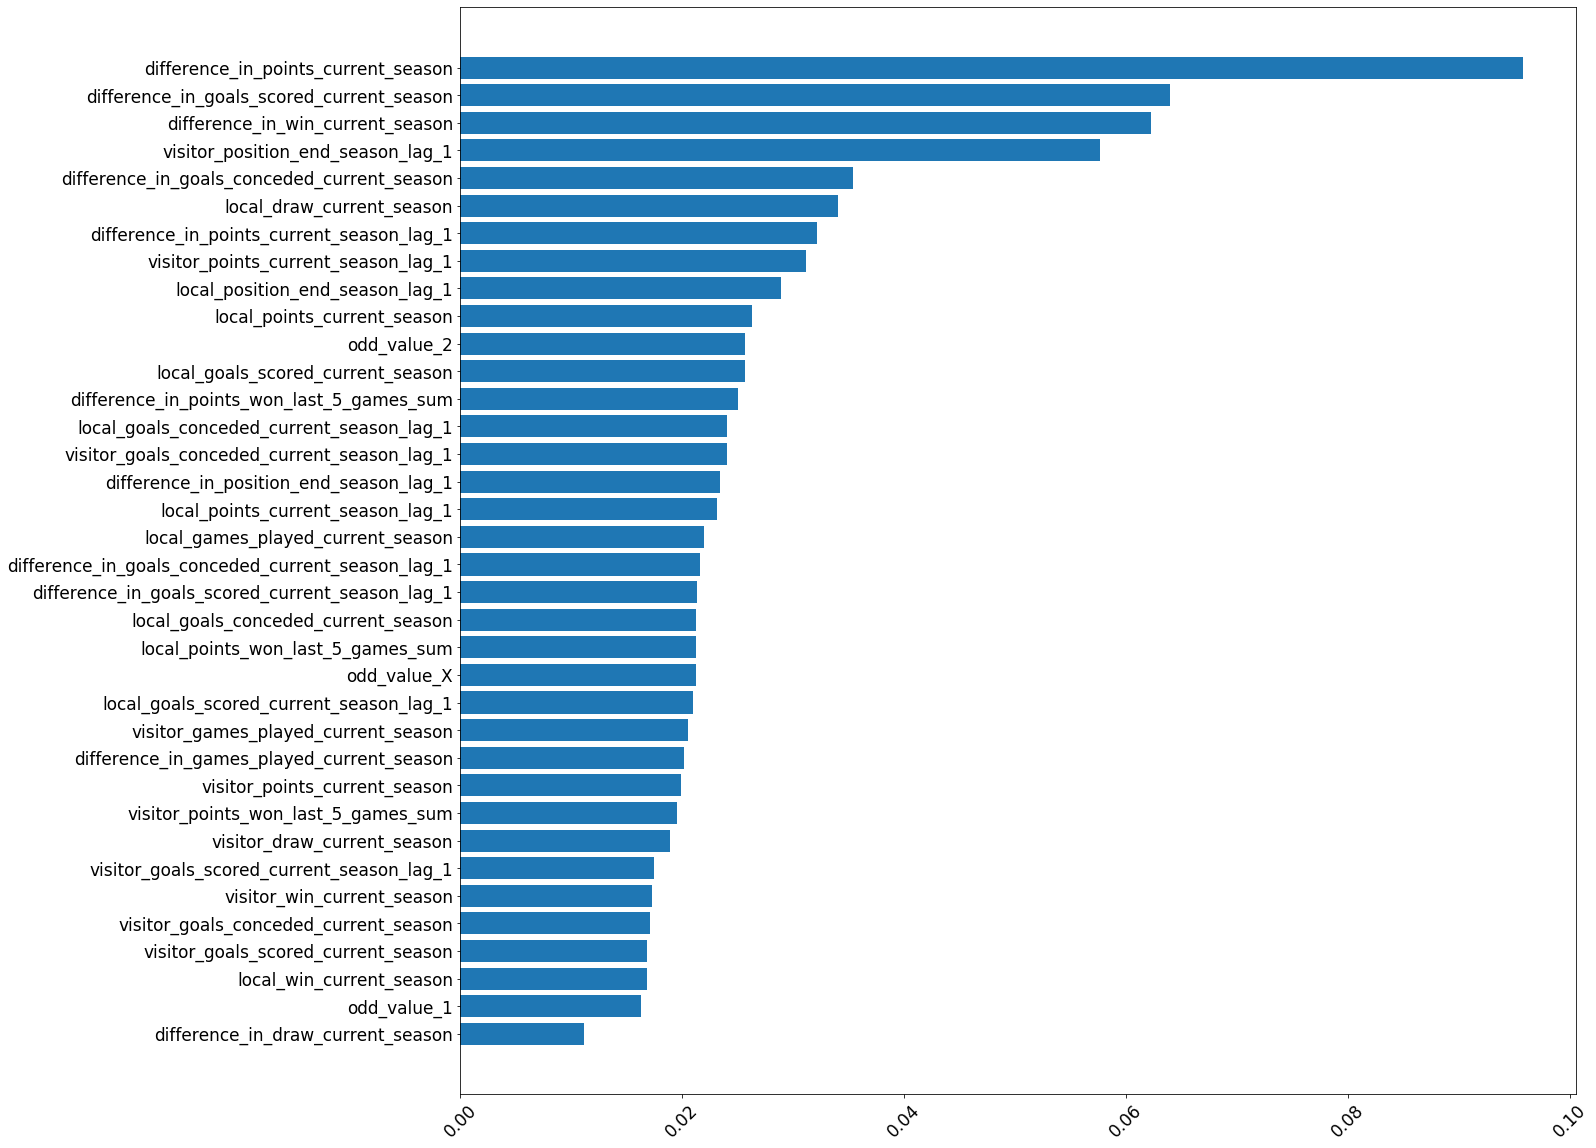

In [180]:
fig, ax = plt.subplots(figsize=(20, 20))
feature_importances = pd.Series({f: imp for f, imp in zip(feature_names, model.feature_importances_)}).sort_values()
ax.barh(feature_importances.index, feature_importances.values)
plt.xticks(rotation=45)
plt.show()

In [181]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
        if i == 1:
            top_parameters = results['params'][candidate]
            
    return top_parameters   


space = {
    'learning_rate': (np.geomspace(1e-2, 1)),
    'max_depth': (range(1, 10)),
    'gamma': (np.geomspace(1e-2, 1)),
    'min_child_weight': (range(1, 10)),
    'n_estimators': (range(30, 300)),
    'reg_alpha': (np.linspace(0.2, 1)),
    'reg_lambda': (np.linspace(0.2, 2)),
}

random_search = RandomizedSearchCV(XGBClassifier(objective='multi:softmax', num_classes=3), param_distributions=space, n_iter=30)
random_search.fit(feature_matrix[feature_names], feature_matrix[target_name])

/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_classes=3,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'learning_rate': array([0.01   , 0.01099, 0.01207, 0.01326, 0.01456, 0.016  , 0.01758,
       0.01931, 0.02121, 0.0233 , 0.0256 , 0.02812, 0.03089, 0.03393,
       0.03728, 0.04095, 0.04498, 0.04942, 0.05429, 0.05964, 0.06551,
       0.07197, 0.07906, 0.08685, 0.09541, 0.10481, ...39, 1.70612,
       1.74286, 1.77959, 1.81633, 1.85306, 1.8898 , 1.92653, 1.96327,
       2.     ])

In [183]:
top_parameters = report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.527 (std: 0.013)
Parameters: {'reg_lambda': 1.3020408163265307, 'reg_alpha': 0.4938775510204082, 'n_estimators': 146, 'min_child_weight': 8, 'max_depth': 1, 'learning_rate': 0.04498432668969444, 'gamma': 0.09540954763499938}

Model with rank: 2
Mean validation score: 0.510 (std: 0.008)
Parameters: {'reg_lambda': 1.5224489795918368, 'reg_alpha': 0.3959183673469388, 'n_estimators': 72, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.015998587196060583, 'gamma': 0.0372759372031494}

Model with rank: 3
Mean validation score: 0.508 (std: 0.014)
Parameters: {'reg_lambda': 0.5306122448979592, 'reg_alpha': 0.9020408163265308, 'n_estimators': 34, 'min_child_weight': 8, 'max_depth': 1, 'learning_rate': 0.07196856730011521, 'gamma': 0.09540954763499938}

Model with rank: 3
Mean validation score: 0.508 (std: 0.014)
Parameters: {'reg_lambda': 1.5591836734693878, 'reg_alpha': 0.28163265306122454, 'n_estimators': 152, 'min_child_weight': 2, 'max_d

In [184]:
#top_parameters = {'reg_lambda': 0.8244897959183675, 'reg_alpha': 0.8204081632653062, 'n_estimators': 91, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.010985411419875584, 'gamma': 0.025595479226995357}

In [185]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)
predict_func = xgboost_fit_predict
splitter = TimeSeriesSplit(6)
all_predictions = []
for train_ix, test_ix in splitter.split(feature_matrix):
    features_train, target_train = feature_matrix.iloc[train_ix][feature_names], feature_matrix.iloc[train_ix][target_name]
    features_test, target_test = feature_matrix.iloc[test_ix][feature_names], feature_matrix.iloc[test_ix][target_name]
    predictions, predictions_proba,  model = predict_func(features_train, target_train, features_test)
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

Accuracy: 0.48
log-loss: 1.02
              precision    recall  f1-score   support

         win       0.52      0.79      0.63       117
        draw       0.32      0.18      0.23        74
        loss       0.50      0.31      0.38        80

   micro avg       0.48      0.48      0.48       271
   macro avg       0.44      0.43      0.41       271
weighted avg       0.46      0.48      0.45       271

Accuracy: 0.5
log-loss: 1.0
              precision    recall  f1-score   support

         win       0.56      0.71      0.63       129
        draw       0.33      0.08      0.12        66
        loss       0.42      0.51      0.46        76

   micro avg       0.50      0.50      0.50       271
   macro avg       0.44      0.43      0.41       271
weighted avg       0.47      0.50      0.46       271

Accuracy: 0.55
log-loss: 0.98
              precision    recall  f1-score   support

         win       0.56      0.89      0.69       136
        draw       0.00      0.00      0.

/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.53
log-loss: 0.99
              precision    recall  f1-score   support

         win       0.54      0.83      0.65       123
        draw       0.10      0.02      0.03        63
        loss       0.56      0.47      0.51        85

   micro avg       0.53      0.53      0.53       271
   macro avg       0.40      0.44      0.40       271
weighted avg       0.44      0.53      0.46       271

Accuracy: 0.5
log-loss: 1.03
              precision    recall  f1-score   support

         win       0.50      0.87      0.64       119
        draw       0.60      0.04      0.08        71
        loss       0.50      0.36      0.42        81

   micro avg       0.50      0.50      0.50       271
   macro avg       0.53      0.42      0.38       271
weighted avg       0.53      0.50      0.42       271

Accuracy: 0.48
log-loss: 1.01
              precision    recall  f1-score   support

         win       0.51      0.80      0.62       128
        draw       0.42      0.07      0

In [186]:
splitter = TimeSeriesSplit(3)
for train_ix, test_ix in splitter.split(feature_matrix.dropna(subset=['odd_value_X'])):
    features_train, target_train = feature_matrix.iloc[train_ix][feature_names], feature_matrix.iloc[train_ix][target_name]
    features_test, target_test = feature_matrix.iloc[test_ix][feature_names], feature_matrix.iloc[test_ix][target_name]
    predictions, predictions_proba,  model = predict_func(features_train, target_train, features_test)
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

Accuracy: 0.55
log-loss: 1.01
              precision    recall  f1-score   support

         win       0.58      0.83      0.68        41
        draw       0.00      0.00      0.00        23
        loss       0.50      0.58      0.54        31

   micro avg       0.55      0.55      0.55        95
   macro avg       0.36      0.47      0.41        95
weighted avg       0.41      0.55      0.47        95

Accuracy: 0.58
log-loss: 0.91
              precision    recall  f1-score   support

         win       0.74      0.63      0.68        54
        draw       0.38      0.20      0.26        15
        loss       0.44      0.69      0.54        26

   micro avg       0.58      0.58      0.58        95
   macro avg       0.52      0.51      0.49        95
weighted avg       0.60      0.58      0.57        95



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.52
log-loss: 1.01
              precision    recall  f1-score   support

         win       0.49      0.89      0.63        37
        draw       0.75      0.10      0.18        29
        loss       0.57      0.45      0.50        29

   micro avg       0.52      0.52      0.52        95
   macro avg       0.60      0.48      0.44        95
weighted avg       0.59      0.52      0.45        95



## Betting

In [187]:
features_with_odds = feature_matrix.dropna(subset=['odd_value_X']).reset_index()
print(features_with_odds.shape)
features_with_odds.head()

(380, 40)


,date,visitor_goals_scored_current_season,odd_value_X,odd_value_1,visitor_points_current_season,local_points_current_season_lag_1,visitor_position_end_season_lag_1,local_games_played_current_season,local_goals_conceded_current_season,local_position_end_season_lag_1,...,difference_in_games_played_current_season,difference_in_goals_conceded_current_season,difference_in_position_end_season_lag_1,difference_in_goals_conceded_current_season_lag_1,difference_in_points_won_last_5_games_sum,difference_in_points_current_season,difference_in_goals_scored_current_season,difference_in_draw_current_season,difference_in_goals_scored_current_season_lag_1,difference_in_win_current_season
0,2018-08-17,0.0,2.40,2.00,0.0,48.0,NaN,0.0,0.0,10.0,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
1,2018-08-17,0.0,2.75,1.83,0.0,60.0,15.0,0.0,0.0,6.0,...,0.0,0.0,-9.0,4.0,-7.0,0.0,0.0,0.0,16.0,0.0
2,2018-08-18,0.0,2.40,2.37,0.0,46.0,11.0,0.0,0.0,13.0,...,0.0,0.0,2.0,16.0,-8.0,0.0,0.0,0.0,20.0,0.0
3,2018-08-18,0.0,2.40,2.50,0.0,60.0,12.0,0.0,0.0,5.0,...,0.0,0.0,-7.0,-10.0,4.0,0.0,0.0,0.0,-11.0,0.0
4,2018-08-18,0.0,5.00,1.16,0.0,90.0,14.0,0.0,0.0,1.0,...,0.0,0.0,-13.0,-20.0,1.0,0.0,0.0,0.0,58.0,0.0


In [191]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)
last_training_date = features_with_odds['date'].min()
features_training = feature_matrix.loc[feature_matrix.index.get_level_values('date') < last_training_date]
xgb.fit(features_training[feature_names], features_training[target_name])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.09540954763499938,
       learning_rate=0.04498432668969444, max_delta_step=0, max_depth=1,
       min_child_weight=8, missing=None, n_estimators=146, n_jobs=1,
       nthread=None, num_classes=3, objective='multi:softprob',
       random_state=0, reg_alpha=0.4938775510204082,
       reg_lambda=1.3020408163265307, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [204]:
def xgboost_predict(features, model):
    predictions = model.predict_proba(features_single_date[feature_names])
    return predictions


def highest_odd(features, model):
    predictions = model.predict_proba(features_single_date[feature_names])
    return predictions


def get_bets_and_expected_gains(expected_value):
    bets = []
    for index, row in expected_value.iterrows():
        max_value = row.max()
        max_name = row.idxmax()
        bet = (row * 0).to_dict()
        bet[max_name] = max_value if max_value > 1 else 0
        bets.append(bet)
    
    bets = pd.DataFrame(bets)
    bets.columns = ['bet_1', 'bet_2', 'bet_X']
    return bets, bets


def dummy_results(target):
    categories = [0, 1, 2]
    results = pd.get_dummies(target).reset_index(drop=True)
    results = results.T.reindex(categories).T.fillna(0)
    return results
    
    
def get_returns(results, bets, odds):
    returns = pd.DataFrame(results.values * bets.values * odds.values, columns=results.columns)
    return returns

predictions_over_time = []
money_bet = []
returns_over_time = []
train_every_n_dates = 10
dates = sorted(features_with_odds['date'].unique())
for i, date in enumerate(dates):
    if i % train_every_n_dates == 0:
        print(pd.Timestamp(date).date())
        features_training = feature_matrix.loc[feature_matrix.index.get_level_values('date') <= date]
        xgb.fit(features_training[feature_names], features_training[target_name])
        
    features_single_date = features_with_odds.loc[features_with_odds['date'] == date]
    odds = features_single_date[['odd_value_1', 'odd_value_2', 'odd_value_X']]
    predictions = xgboost_predict(features_single_date[feature_names], xgb)
    expected_value = odds * predictions
    bets, expected_gains = get_bets_and_expected_gains(expected_value)
    money_in_play = bets.sum().sum()
    results = dummy_results(features_single_date[target_name])
    returns = get_returns(results, bets, odds)
    total_returns_single_date = returns.sum().sum() - money_in_play
    returns_over_time.append(total_returns_single_date)
    money_bet.append(money_in_play)
    predictions = pd.DataFrame(predictions)
    predictions['local_name'] = features_single_date['local_name'].tolist()
    predictions['date'] = features_single_date['date'].tolist()
    predictions_over_time.append(predictions)

print('Done')
returns_over_time = pd.Series(returns_over_time, index=dates).sort_index()
money_bet_over_time = pd.Series(money_bet, index=dates).sort_index()
predictions_over_time = pd.concat(predictions_over_time)
predictions_over_time['prediction'] = predictions_over_time[[0, 1, 2]].idxmax(axis=1)
predictions_and_features = features_with_odds.set_index(['local_name', 'date']).join(
    predictions_over_time.set_index(['local_name', 'date']),
)
predictions_and_features['correct_prediction'] = predictions_and_features['result_num'] == predictions_and_features['prediction']
predictions_and_target = features_with_odds.set_index(['local_name', 'date'])[[target_name]].astype(int).join(
    predictions_over_time.set_index(['local_name', 'date']),
)

print(f"Accuracy over time: {(predictions_and_target.dropna()['result_num'] == predictions_and_target.dropna()['prediction']).mean()}")
print(f"log-loss over time: {log_loss(predictions_and_target['result_num'], predictions_and_target[[0, 1, 2]])}") 

2018-08-17
2018-09-02
2018-09-27
2018-10-21
2018-11-10
2018-12-07
2018-12-23
2019-01-18
2019-02-04
2019-02-23
2019-03-15
2019-04-07
2019-04-27
Done
Accuracy over time: 0.4605263157894737
log-loss over time: 1.0339094921162253


In [138]:
features_single_date[['local_name', 'visitor_name', 'result_num', 'local_win_current_season',
                      'visitor_win_current_season', 'local_goals_scored_current_season', 'local_goals_conceded_current_season',
                     'visitor_goals_scored_current_season', 'visitor_goals_conceded_current_season']]

,local_name,visitor_name,result_num,local_win_current_season,visitor_win_current_season,local_goals_scored_current_season,local_goals_conceded_current_season,visitor_goals_scored_current_season,visitor_goals_conceded_current_season
378,Real Madrid,Real Betis,2.0,21.0,13.0,63.0,44.0,42.0,52.0
379,SD Eibar,Barcelona,1.0,11.0,26.0,44.0,48.0,88.0,34.0


In [85]:
features_with_odds.loc[features_with_odds['date'] == '2018-09-23'][['local_name', 'visitor_name', 'result_num']]

,local_name,visitor_name,result_num
45,Levante,Sevilla,2.0
46,Villarreal,Valencia,1.0
47,Real Betis,Athletic Club,1.0
48,Barcelona,Girona,1.0


In [142]:
predictions_and_features.head()

,,visitor_goals_scored_current_season,odd_value_X,odd_value_1,visitor_points_current_season,local_points_current_season_lag_1,visitor_position_end_season_lag_1,local_games_played_current_season,local_goals_conceded_current_season,local_position_end_season_lag_1,odd_value_2,...,local_draw_current_season,local_goals_scored_current_season_lag_1,local_win_current_season,visitor_name,result_num,0,1,2,prediction,correct_prediction
local_name,date,,,,,,,,,,,,,,,,,,,,,
Girona,2018-08-17,0.0,2.40,2.00,0.0,48.0,NaN,0.0,0.0,10.0,4.75,...,0.0,48.0,0.0,Real Valladolid,1.0,0.411208,0.308900,0.279891,0,False
Real Betis,2018-08-17,0.0,2.75,1.83,0.0,60.0,15.0,0.0,0.0,6.0,4.75,...,0.0,58.0,0.0,Levante,2.0,0.436940,0.333668,0.229392,0,False
Celta de Vigo,2018-08-18,0.0,2.40,2.37,0.0,46.0,11.0,0.0,0.0,13.0,3.60,...,0.0,55.0,0.0,Espanyol,1.0,0.461243,0.306975,0.231783,0,False
Villarreal,2018-08-18,0.0,2.40,2.50,0.0,60.0,12.0,0.0,0.0,5.0,3.25,...,0.0,55.0,0.0,Real Sociedad,2.0,0.361601,0.442493,0.195906,1,False
Barcelona,2018-08-18,0.0,5.00,1.16,0.0,90.0,14.0,0.0,0.0,1.0,17.00,...,0.0,98.0,0.0,Deportivo Alavés,0.0,0.672768,0.168129,0.159102,0,True


In [147]:
predictions_and_features.loc[predictions_and_features.index.get_level_values('date') == '2018-09-23'][['visitor_name', 'prediction', 'result_num']]

,,visitor_name,prediction,result_num
local_name,date,,,
Levante,2018-09-23,Sevilla,0,2.0
Villarreal,2018-09-23,Valencia,0,1.0
Real Betis,2018-09-23,Athletic Club,0,1.0
Barcelona,2018-09-23,Girona,0,1.0


In [203]:
returns_over_time

2018-08-17    3.712050
2018-08-18   -5.997622
2018-08-19   -5.373207
2018-08-20   -2.750292
2018-08-24   -2.229716
                ...   
2019-05-04   -3.115409
2019-05-05    6.486499
2019-05-12   -8.859310
2019-05-18    7.599873
2019-05-19   -3.244702
Length: 129, dtype: float64

In [205]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [201]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.cumsum().values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Cumulative returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [207]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list((returns_over_time.cumsum() / money_bet_over_time.cumsum()).values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'ROI over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'ROI',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [209]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list((returns_over_time / money_bet_over_time).values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'ROI per date',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'ROI',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

Total returns after 129 betting days: 127.88610497493147


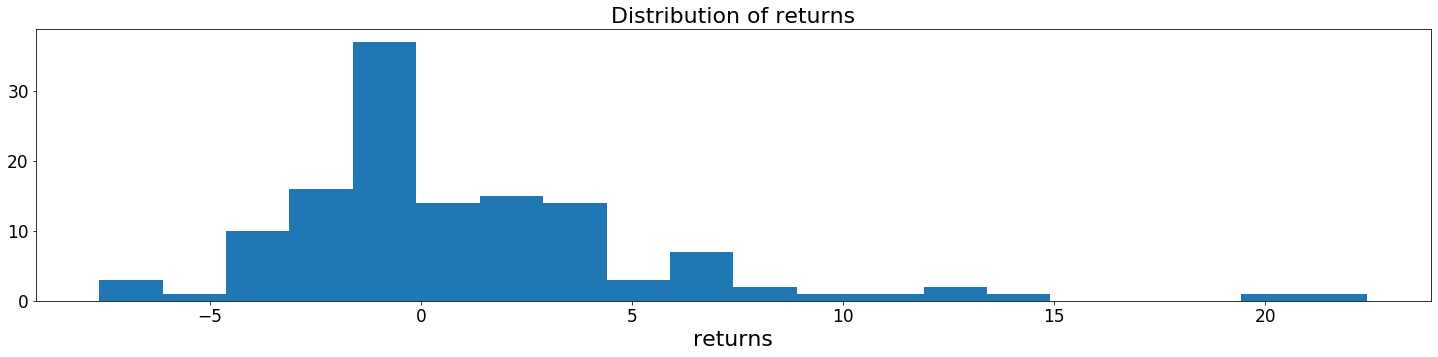

In [68]:
print(f'Total returns after {features_with_odds.date.nunique()} betting days: {np.sum(returns_over_time)}')
fig, ax = plt.subplots(figsize=(25, 5))
ax.hist(returns_over_time, bins=20)
ax.set_title('Distribution of returns')
ax.set_xlabel('returns')
plt.show()